In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import multivariate_normal as mvnorm
from datetime import datetime
now = datetime.now

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define IBP class

In [3]:
from collections import namedtuple
import numpy as np
from scipy.special import digamma, betaln

variational_pars = namedtuple("var_pars", ["mu", "phi", "tau_1", "tau_2", "nu"])

class IBP_VI:
    def __init__(self, alpha = None, sigma_n = None, sigma_a = None, K=None):
        # hyperparameters
        self.alpha = alpha
        self.sigma_a = sigma_a
        self.sigma_n = sigma_n

        # number of features
        self.K = K

        self.data = None
        self.N = None
        self.D = None

    def init_pars(self):
        # haven't decided whether random or fixed init is better

        # tau_1 = np.random.gamma(2, 2, size=self.K)
        # tau_2 = np.random.gamma(2, 2, size=self.K)
        tau_1 = np.ones((self.K,))
        tau_2 = np.ones((self.K,))

        nu = np.random.beta(1, 2, size=(self.N, self.K))

        # mu = np.random.normal(0, 1, size=(self.K, self.D))
        mu = np.zeros((self.K, self.D))
        # phi = np.stack([np.random.gamma(1, 1) * np.identity(self.K)
        #             for _ in range(self.K)])
        phi = np.stack([np.identity(self.K) for _ in range(self.K)])

        return variational_pars(mu, phi, tau_1, tau_2, nu)

    def update_pars(self, pars):
        mu_updated = self.update_mu(pars.nu, pars.mu)
        phi_updated = self.update_phi(pars.nu)
        nu_updated = self.update_nu(pars.tau_1, pars.tau_2,
                phi_updated, mu_updated, pars.nu)
        tau_1_updated, tau_2_updated = self.update_tau(nu_updated)

        return variational_pars(mu_updated, phi_updated, tau_1_updated,
                tau_2_updated, nu_updated)

    def update_tau(self, nu):
        nu_sum = nu.sum(axis=0)
        return self.alpha / self.K + nu_sum, self.N + 1 - nu_sum

    def update_mu(self, nu, mu):
        mu_new = mu.copy()
        den = (1 / self.sigma_a + nu.sum(axis=0) / self.sigma_n)

        for k in range(self.K):
            inner_sum = nu[:, :, None] * mu_new
            inner_sum[:, k] = 0

            num = inner_sum.sum(axis=1)
            num = np.sum(nu[:, k, None] * (self.data - num), axis=0)
            num /= self.sigma_n
            
            mu_new[k] = num / den[k]

        return mu_new

    def update_phi(self, nu):
        scaling = nu.sum(axis=0) / self.sigma_n
        scaling += 1 / self.sigma_a

        phi_new = [np.identity(self.K) / scaling[k] for k in range(self.K)]

        return np.stack(phi_new)

    def update_nu(self, tau_1, tau_2, phi, mu, nu):
        # nu_new = np.zeros((self.N, self.K))
        nu_new = nu.copy()
        for i in range(self.N):
            for k in range(self.K):
                exponent = digamma(tau_1[k]) - digamma(tau_2[k])
                exponent -= (1 / (2 * self.sigma_n)) * (np.trace(phi[k]) + 
                        np.dot(mu[k], mu[k]))

                inner_term = nu_new[i, :, None] * mu
                inner_term[k] = 0
                exponent += (1 / self.sigma_n) * np.dot(mu[k],
                        (self.data[i] - inner_term.sum(axis=0)))

                nu_new[i, k] = 1 / (1 + np.exp(-exponent))

        return nu_new

    # def update_nu(self):
    #     pass

    def elbo(self, pars):
        """
        The equations are absolutely horrible
        """
        model_cross_entropy = 0

        # sticks
        model_cross_entropy += self.K * np.log(self.alpha / self.K) + \
                (self.alpha / self.K - 1) * np.sum(digamma(pars.tau_1) - \
                digamma(pars.tau_1 + pars.tau_2))

        # Z
        model_cross_entropy += np.sum(pars.nu * digamma(pars.tau_1) + \
                (1 - pars.nu) * digamma(pars.tau_2)) - \
                self.N * digamma(pars.tau_1 + pars.tau_2).sum()
        
        # A
        model_cross_entropy -= (self.K * self.D) / 2 * np.log(2 * np.pi * 
                self.sigma_a) + 1 / (2 * self.sigma_a) * \
                        np.sum(np.trace(pars.phi, axis1 = 1, axis2 = 2)) + \
                        np.trace(np.dot(pars.mu, pars.mu.T))

        # X
        model_cross_entropy -= (self.N * self.D) / 2 * np.log(2 * np.pi * 
                self.sigma_n)
        model_cross_entropy -= 1 / (2 * self.sigma_n) * (
                np.trace(np.dot(self.data, self.data.T)) - \
                2 * np.sum(pars.nu * np.dot(self.data, pars.mu.T)) + \
                np.sum(pars.nu * (np.trace(pars.phi, axis1 = 1, axis2 = 2) +
                                  np.diagonal(np.dot(pars.mu, pars.mu.T))))
                )
        for i in range(self.N):
            model_cross_entropy -= 1 / self.sigma_n * np.sum(np.tril(
                np.outer(pars.nu[i], pars.nu[i]) * np.dot(pars.mu, pars.mu.T),
                k = -1))

        var_entropy = 0

        # sticks
        var_entropy += np.sum(
                betaln(pars.tau_1, pars.tau_2) - \
                (pars.tau_1 - 1) * digamma(pars.tau_1) - \
                (pars.tau_2 - 1) * digamma(pars.tau_2) + \
                (pars.tau_1 + pars.tau_2 - 2) * digamma(pars.tau_1 + pars.tau_2)
                )

        # Z
        var_entropy += np.sum(
                -pars.nu * np.log(pars.nu) - \
                (1 - pars.nu) * np.log(1 - pars.nu)
                )

        # A
        # note since phi is always diagonal, the det is just diagonal product
        _, det_phi = np.linalg.slogdet(pars.phi)
        var_entropy += (self.K * self.D) / 2 * np.log(2 * np.pi) + \
                (self.K * self.D) / 2 + \
                det_phi.sum()

        return model_cross_entropy + var_entropy

    def posterior_expectations(self, pars):
        return (self.sticks_expectation(pars.tau_1, pars.tau_2),
                self.Z_expectation(pars.nu), self.A_expectation(pars.mu))

    def sticks_expectation(self, tau_1, tau_2):
        return tau_1 / (tau_1 + tau_2)

    def Z_expectation(self, nu):
        return nu

    def A_expectation(self, mu):
        return mu

    def data_expectation(self, nu, mu):
        return np.dot(nu, mu)

    def observe(self, data):
        self.data = data
        self.N, self.D = data.shape

    def infer(self, data, n_iter=2000):
        if self.data is None:
            self.observe(data)

        elbos = np.zeros(n_iter)
        pars = self.init_pars()

        for i in range(n_iter):
            pars = self.update_pars(pars)
            # print(np.sum((self.data_expectation(pars.nu, pars.mu) - \
            #         self.data) ** 2))
            elbos[i] = self.elbo(pars)

        return pars, elbos

if __name__ == "__main__":
    test = IBP_VI(alpha = 5, sigma_a = 1, sigma_n = 1, K = 10)

    data = np.random.normal(size=(50, 5))
    test.observe(data)

    pars = test.init_pars()


Generate Synthetic data

(-0.0007358078362880577, 0.9936887650033385)

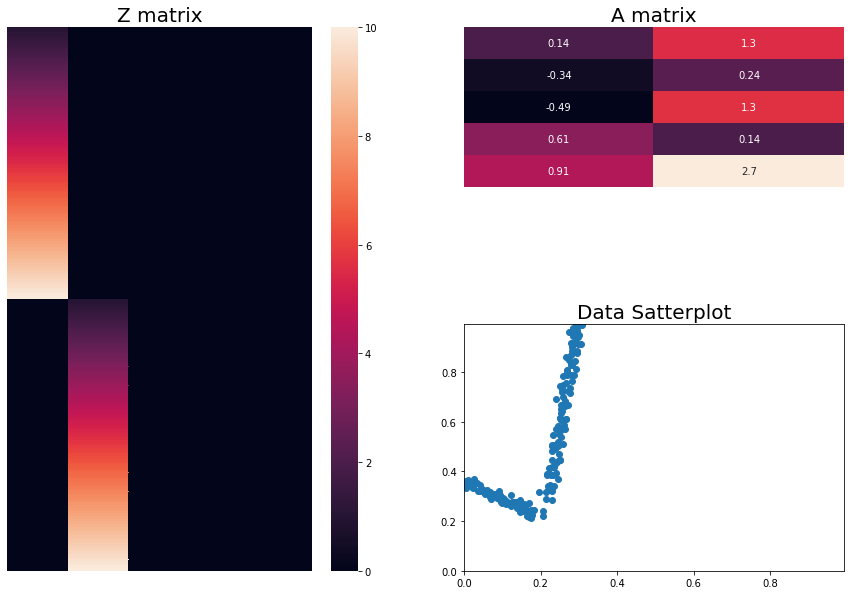

In [8]:
# Ground truth definition
gK = 5 # How many factors (not all have ot active)
D = 2 # Dimensionality of the data
N = 200 # N datapoints

Z = np.zeros((N,gK)) # pre-allocate Z matrix

case = 4

if case==1: #One factor
    Z[:,0]=1
    #Z[int(N/2):-1,0]=1
elif case==2: #Two ofactors
    #Z[::2,0]=1
    Z[:,0]=1
    Z[1::2,1]=1
elif case==3: # Three factors
    Z[0::3,0]=1
    Z[1::3,1]=1
    Z[2::3,2]=1
elif case==4: # Two factors graded
    #Z[:,0]=1
    #Z[:,1]=1
    Z[0:int(N/2),0] = np.linspace(1.,10,int(N/2))
    Z[int(N/2):,1] = np.linspace(1.,10,int(N/2))
    #Z[0:int(N/2),0] = 1
    #Z[int(N/2):,1] = 1
    #Z[int(N*.3):int(N*2/3):,2] = 1

# Plot Z matrix    
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.heatmap(Z,annot=False)
plt.title('Z matrix',fontsize=20)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);

# Sample an A matrix
cov = np.eye(D);
A = mvnorm(mean=np.zeros(D), cov=cov).rvs(gK)
#A = np.array(([ 0.37880717,  1.29126631],[ 0.94770151,  0.07006182],[-0.42720817,  1.09532847]))

# Plot A
plt.subplot(3,2,2)
sns.heatmap(A,annot=True,cbar=False)
plt.title('A matrix',fontsize=20)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);

# Data 
data = np.matmul(Z,A) # Data is Z*A
e = np.random.randn(data.shape[0],data.shape[1])*0.01 # Some error

# Normalise data?
#data = data / data.sum(axis=0) #Normalise
data = data-data.min()
data /= data.max() #Normalise
#data *= 100 # Scale
data = data+e # Add error
#data *= 10

# #plt.figure()
# plt.subplot(3,2,4)
# sns.heatmap(data[0:10,:],annot=True,cbar=False)
# plt.title('Data',fontsize=20)
# plt.xticks(ticks=[]);plt.yticks(ticks=[]);

plt.subplot(2,2,4)
plt.scatter(data[:,0],data[:,1])
plt.title('Data Satterplot',fontsize=20)
plt.xlim((data.min(),data.max()))
plt.ylim((data.min(),data.max()))

#plt.tight_layout()

Run IBP VI inference

In [9]:
data = np.array(data); # Make sure it's an array
t0 = now() # Start a timer
print(t0) # When started
IBP = IBP_VI(alpha = 1, sigma_n = 1, sigma_a = 1, K=5); # Initialise IBP
pars, elbos = IBP.infer(data,n_iter=500) # Run inference
mu_updated, phi_updated, tau_1_updated,tau_2_updated, nu_updated = pars # Get output

print(F"done in {str(now()-t0)}")

2020-08-20 20:26:55.920136
done in 0:00:26.236349


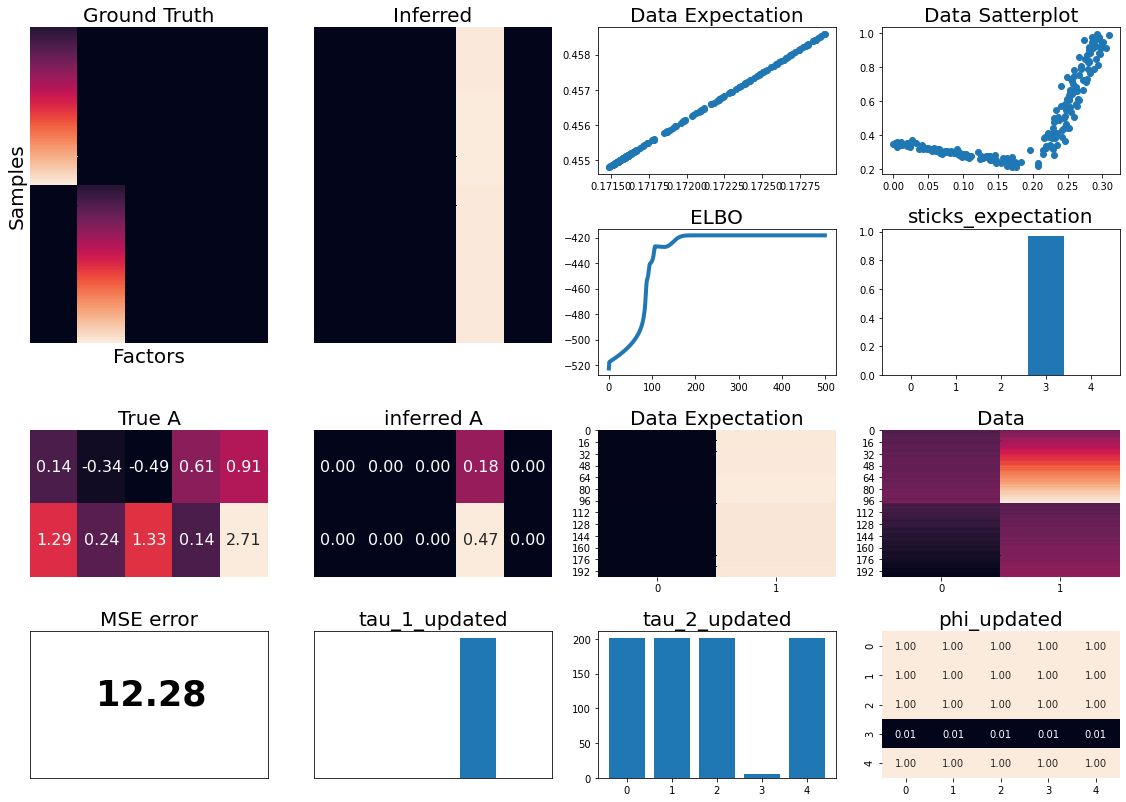

In [10]:
plt.figure(figsize=np.array((7,5))*2.25)

plt.subplot(2,4,1)
sns.heatmap(Z,annot=False,cbar=False)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);
plt.title('Ground Truth',fontsize=20)
plt.ylabel('Samples',fontsize=20);
plt.xlabel('Factors',fontsize=20);


plt.subplot(2,4,2)
sns.heatmap(nu_updated,annot=False,cbar=False)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);
plt.title('Inferred',fontsize=20)


plt.subplot(4,4,3)
DE = IBP.data_expectation(nu_updated,mu_updated)
plt.scatter(DE[:,0],DE[:,1])
plt.title('Data Expectation',fontsize=20)


plt.subplot(4,4,4)
plt.scatter(data[:,0],data[:,1])
plt.title('Data Satterplot',fontsize=20)

plt.subplot(4,4,7)
plt.plot(elbos,linewidth=4)
plt.title('ELBO',fontsize=20)
#plt.legend('ELBO',fontsize=20)

plt.subplot(4,4,8)
y = IBP.posterior_expectations(pars)[0]
x = np.arange(len(y))
plt.bar(x,y)
plt.title('sticks_expectation',fontsize=20)

plt.subplot(4,4,9)
sns.heatmap(A.transpose(),annot=True,cbar=False,annot_kws={"fontsize" : 16},fmt='.2f')
plt.title('True A',fontsize=20)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);

plt.subplot(4,4,10)
sns.heatmap(mu_updated.transpose(),annot=True,cbar=False,annot_kws={"fontsize" : 16},fmt='.2f')
plt.title('inferred A',fontsize=20)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);

plt.subplot(4,4,11)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);
sns.heatmap(DE,cbar=False)
plt.title('Data Expectation',fontsize=20)

plt.subplot(4,4,12)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);
sns.heatmap(data,cbar=False)
plt.title('Data',fontsize=20)


plt.subplot(4,4,13)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);
plt.text(1-.45,1,'{:.2f}'.format(np.sum(np.array(data-DE)**2)),fontsize=35,fontweight='bold')
plt.ylim(0,2);plt.xlim(0,2)
plt.title('MSE error',fontsize=20)


plt.subplot(4,4,14)
plt.xticks(ticks=[]);plt.yticks(ticks=[]);
y = tau_1_updated
x = np.arange(len(y))
plt.bar(x,y)
plt.title('tau_1_updated',fontsize=20)


plt.subplot(4,4,15)
y = tau_2_updated
x = np.arange(len(y))
plt.title('tau_2_updated',fontsize=20)
plt.bar(x,y)

plt.subplot(4,4,16)
sns.heatmap(phi_updated.sum(axis=2),annot=True,cbar=False,fmt='.2f')
plt.title('phi_updated',fontsize=20)

plt.tight_layout()

ELBO: 813.868 , MSE: 0.086


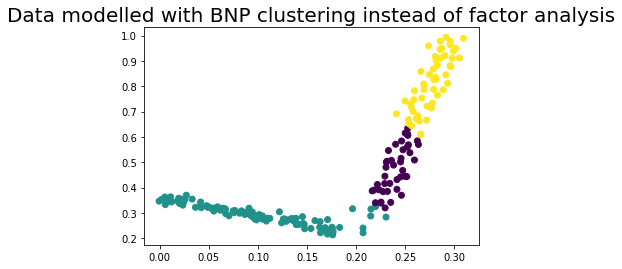

In [11]:
# Fit clustering on the same data
from sklearn.mixture import BayesianGaussianMixture as BNP 
model = BNP(max_iter=100000,
n_components=5,
covariance_type=['full','tied','diag' ,'spherical'][2],
init_params='random',tol=1e-5,
weight_concentration_prior_type='dirichlet_process',
weight_concentration_prior=1,
mean_precision_prior=1,
degrees_of_freedom_prior=None)
cid = model.fit_predict(data)

plt.figure(figsize=(6,4))
plt.scatter(data[:,0],data[:,1],c=cid)
ELBO_C = model.lower_bound_
MSE_C = np.mean((model.sample(N)[0]-data)**2)
plt.title('Data modelled with BNP clustering instead of factor analysis',fontsize=20)
print(F"ELBO: {np.round(ELBO_C,3)} , MSE: {np.round(MSE_C,3)}")